In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

from imblearn.under_sampling import RandomUnderSampler

In [3]:
class AudioDataset(Dataset):
    def __init__(self, mfcc_features, labels):
        self.features = torch.FloatTensor(mfcc_features)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class Simple1DCNN(nn.Module):
    def __init__(self, input_features=40, input_length=200):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_features, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # Calculate size after first Conv and Pool
        self.size_after_conv1 = (input_length + 2*1 - 3) // 1 + 1
        self.size_after_pool1 = (self.size_after_conv1 - 2) // 2 + 1

        self.flatten = nn.Flatten()
        # Adjust the linear layer size
        self.fc = nn.Linear(64 * self.size_after_pool1, 2)

    def forward(self, x):
        x = self.pool1(nn.ReLU()(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc = [], []
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_acc[-1]*100:.2f}% - Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_acc[-1]*100:.2f}%')

    return model, train_acc, val_acc, train_losses, val_losses


In [9]:
def load_mfcc(path):
    
    # Load the concatenated MFCC data
    data = np.load(path)
    return data['X'], data['y']

X_train, y_train = load_mfcc('DAIC_mcc_train.npz')
X_test, y_test = load_mfcc('DAIC_mcc_test.npz')

# Flatten the MFCC data from 3D to 2D for resampling
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_flattened, y_train)
X_test_resampled, y_test_resampled = rus.fit_resample(X_test_flattened, y_test)

# Check the balance
print("Before balancing:", np.bincount(y_train))
print("After balancing:", np.bincount(y_train_resampled))
print("Before balancing:", np.bincount(y_test))
print("After balancing:", np.bincount(y_test_resampled))

# Optional: Reshape back to 3D if your model requires
X_train_resampled_3d = X_train_resampled.reshape(-1, 40, 200)  # Modify dimensions as necessary
X_test_resampled_3d = X_test_resampled.reshape(-1, 40, 200)  # Modify dimensions as necessary

Before balancing: [4378 1781]
After balancing: [1781 1781]
Before balancing: [967 712]
After balancing: [712 712]


In [6]:
# shuffle X_train_resampled_3d and y_train_resampled, and split into train and validation sets
from sklearn.model_selection import train_test_split
X_train_resampled_3d, X_val_resampled_3d, y_train_resampled, y_val_resampled = train_test_split(X_train_resampled_3d, y_train_resampled, test_size=0.2, random_state=42)

In [10]:


dataset_train = AudioDataset(X_train_resampled_3d, y_train_resampled)
dataset_val = AudioDataset(X_test_resampled_3d, y_test_resampled)

# use just the train
#dataset_train = AudioDataset(X_train_resampled_3d, y_train_resampled)
#dataset_val = AudioDataset(X_val_resampled_3d, y_val_resampled)

In [11]:
MAX_SEGMENT_LENGTH = 200
BATCH_SIZE = 32

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple1DCNN(input_length=MAX_SEGMENT_LENGTH).to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
model, train_acc, val_acc, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001)


Epoch 1/50 - Train Loss: 0.7287 - Train Acc: 50.11% - Val Loss: 0.7327 - Val Acc: 48.95%
Epoch 2/50 - Train Loss: 0.6662 - Train Acc: 57.58% - Val Loss: 0.7759 - Val Acc: 50.07%
Epoch 3/50 - Train Loss: 0.6282 - Train Acc: 63.81% - Val Loss: 0.7986 - Val Acc: 49.72%
Epoch 4/50 - Train Loss: 0.5800 - Train Acc: 69.62% - Val Loss: 0.8035 - Val Acc: 48.10%
Epoch 5/50 - Train Loss: 0.5369 - Train Acc: 71.48% - Val Loss: 0.8205 - Val Acc: 51.83%
Epoch 6/50 - Train Loss: 0.5221 - Train Acc: 72.32% - Val Loss: 0.8853 - Val Acc: 50.84%
Epoch 7/50 - Train Loss: 0.4832 - Train Acc: 75.58% - Val Loss: 1.0392 - Val Acc: 50.70%
Epoch 8/50 - Train Loss: 0.4494 - Train Acc: 78.47% - Val Loss: 0.9369 - Val Acc: 50.35%
Epoch 9/50 - Train Loss: 0.4224 - Train Acc: 79.25% - Val Loss: 1.0498 - Val Acc: 48.95%
Epoch 10/50 - Train Loss: 0.3768 - Train Acc: 82.57% - Val Loss: 1.0725 - Val Acc: 48.24%
Epoch 11/50 - Train Loss: 0.3667 - Train Acc: 83.10% - Val Loss: 1.1042 - Val Acc: 49.23%
Epoch 12/50 - Train

KeyboardInterrupt: 

### Random dummy for development purposes

Epoch 1/50 - Train Loss: 0.5508 - Train Acc: 80.00% - Val Loss: 0.1929 - Val Acc: 95.00%
Epoch 2/50 - Train Loss: 0.1733 - Train Acc: 95.00% - Val Loss: 0.0757 - Val Acc: 100.00%
Epoch 3/50 - Train Loss: 0.0545 - Train Acc: 100.00% - Val Loss: 0.0335 - Val Acc: 100.00%
Epoch 4/50 - Train Loss: 0.0288 - Train Acc: 100.00% - Val Loss: 0.0226 - Val Acc: 100.00%
Epoch 5/50 - Train Loss: 0.0194 - Train Acc: 100.00% - Val Loss: 0.0158 - Val Acc: 100.00%
Epoch 6/50 - Train Loss: 0.0143 - Train Acc: 100.00% - Val Loss: 0.0121 - Val Acc: 100.00%
Epoch 7/50 - Train Loss: 0.0114 - Train Acc: 100.00% - Val Loss: 0.0100 - Val Acc: 100.00%
Epoch 8/50 - Train Loss: 0.0095 - Train Acc: 100.00% - Val Loss: 0.0085 - Val Acc: 100.00%
Epoch 9/50 - Train Loss: 0.0081 - Train Acc: 100.00% - Val Loss: 0.0073 - Val Acc: 100.00%
Epoch 10/50 - Train Loss: 0.0070 - Train Acc: 100.00% - Val Loss: 0.0064 - Val Acc: 100.00%
Epoch 11/50 - Train Loss: 0.0062 - Train Acc: 100.00% - Val Loss: 0.0057 - Val Acc: 100.00%


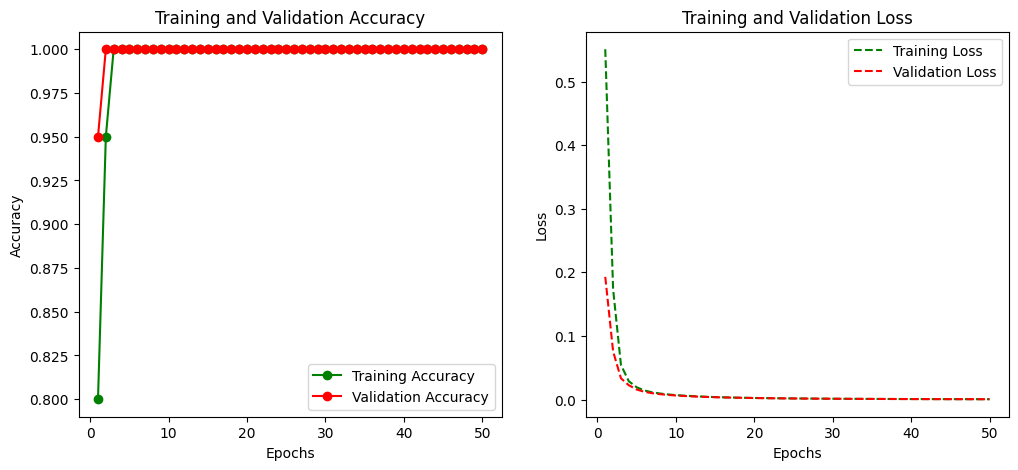

In [11]:
    # Dummy data (10 samples, 40 MFCC features, varying length of 150)
PARTICIPANTS = 20 # automatically has to be defined 
MFCC_LENGTH = 50 # I have to control the numbeer of MFCC features (so like cutting or whatever)

mfcc_features = np.random.randn(PARTICIPANTS, 40, MFCC_LENGTH) # 10 pcs of 40 MFCC features with length of 150
# (200, 40, 500) 
labels = np.random.randint(0, 2, size=(PARTICIPANTS,)) # so the labels 0 2 means labels between 0 and 1

dataset = AudioDataset(mfcc_features, labels)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple1DCNN(input_length=MFCC_LENGTH).to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
model, train_acc, val_acc, train_losses, val_losses = train_model(model, loader, loader, num_epochs=50, learning_rate=0.001)
plot_results(train_acc, val_acc, train_losses, val_losses)

In [2]:
import torch

# Basic check if CUDA is available
is_cuda = torch.cuda.is_available()
print(f"CUDA available: {is_cuda}")

# If you want more details:
if is_cuda:
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

CUDA available: True
Current CUDA device: 0
Device name: NVIDIA GeForce GTX 1650 Ti
Number of GPUs: 1


In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda) 

2.3.1+cu118
11.8
